# Question 4

### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [8]:
#Function and Data Dependancies

#Importing Packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
import datetime

xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projectionimport cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

#Creating the Plot Data from Dataset

monthly_avg = ds.resample(time="1MS").mean() #Organize by month then take the mean
climatology_avg = ds.isel(time=(ds['time.year'] > 2001) & (ds['time.year'] < 2013)).groupby('time.month').mean()[['analysed_sst']]   # Select the appropriate timeframe and take the monthly means between 2002 and 2012
monthly_data = monthly_avg.isel(time=(monthly_avg['time.year'] > 2013) & (monthly_avg['time.year'] < 2017)) #Select the appropriate timeframe of monthly means

monthly_anomalies = monthly_data.groupby("time.month") - climatology_avg #Calculate the anomalies by subtracting the monthly means in climatology_avg



In [9]:
# calculating the stds for each month, longitude, latitude for the years of 2002-2012
climatology_sds = ds.isel(time=(ds['time.year'] > 2001) & (ds['time.year'] < 2013)).groupby('time.month').std()[['analysed_sst']]

#setting up the monthly absolute value comparison
abs_data = abs(monthly_anomalies).groupby("time.month")

#creating the boolean mask comparison
mask = abs_data < climatology_sds['analysed_sst']

#actually masking the non-absolute data, if the absolute value of the analysed_sst value is less than the std for that area between 2002-2012, then it is replaced with 0
monthly_anomalies = monthly_anomalies.where(~mask, 0)

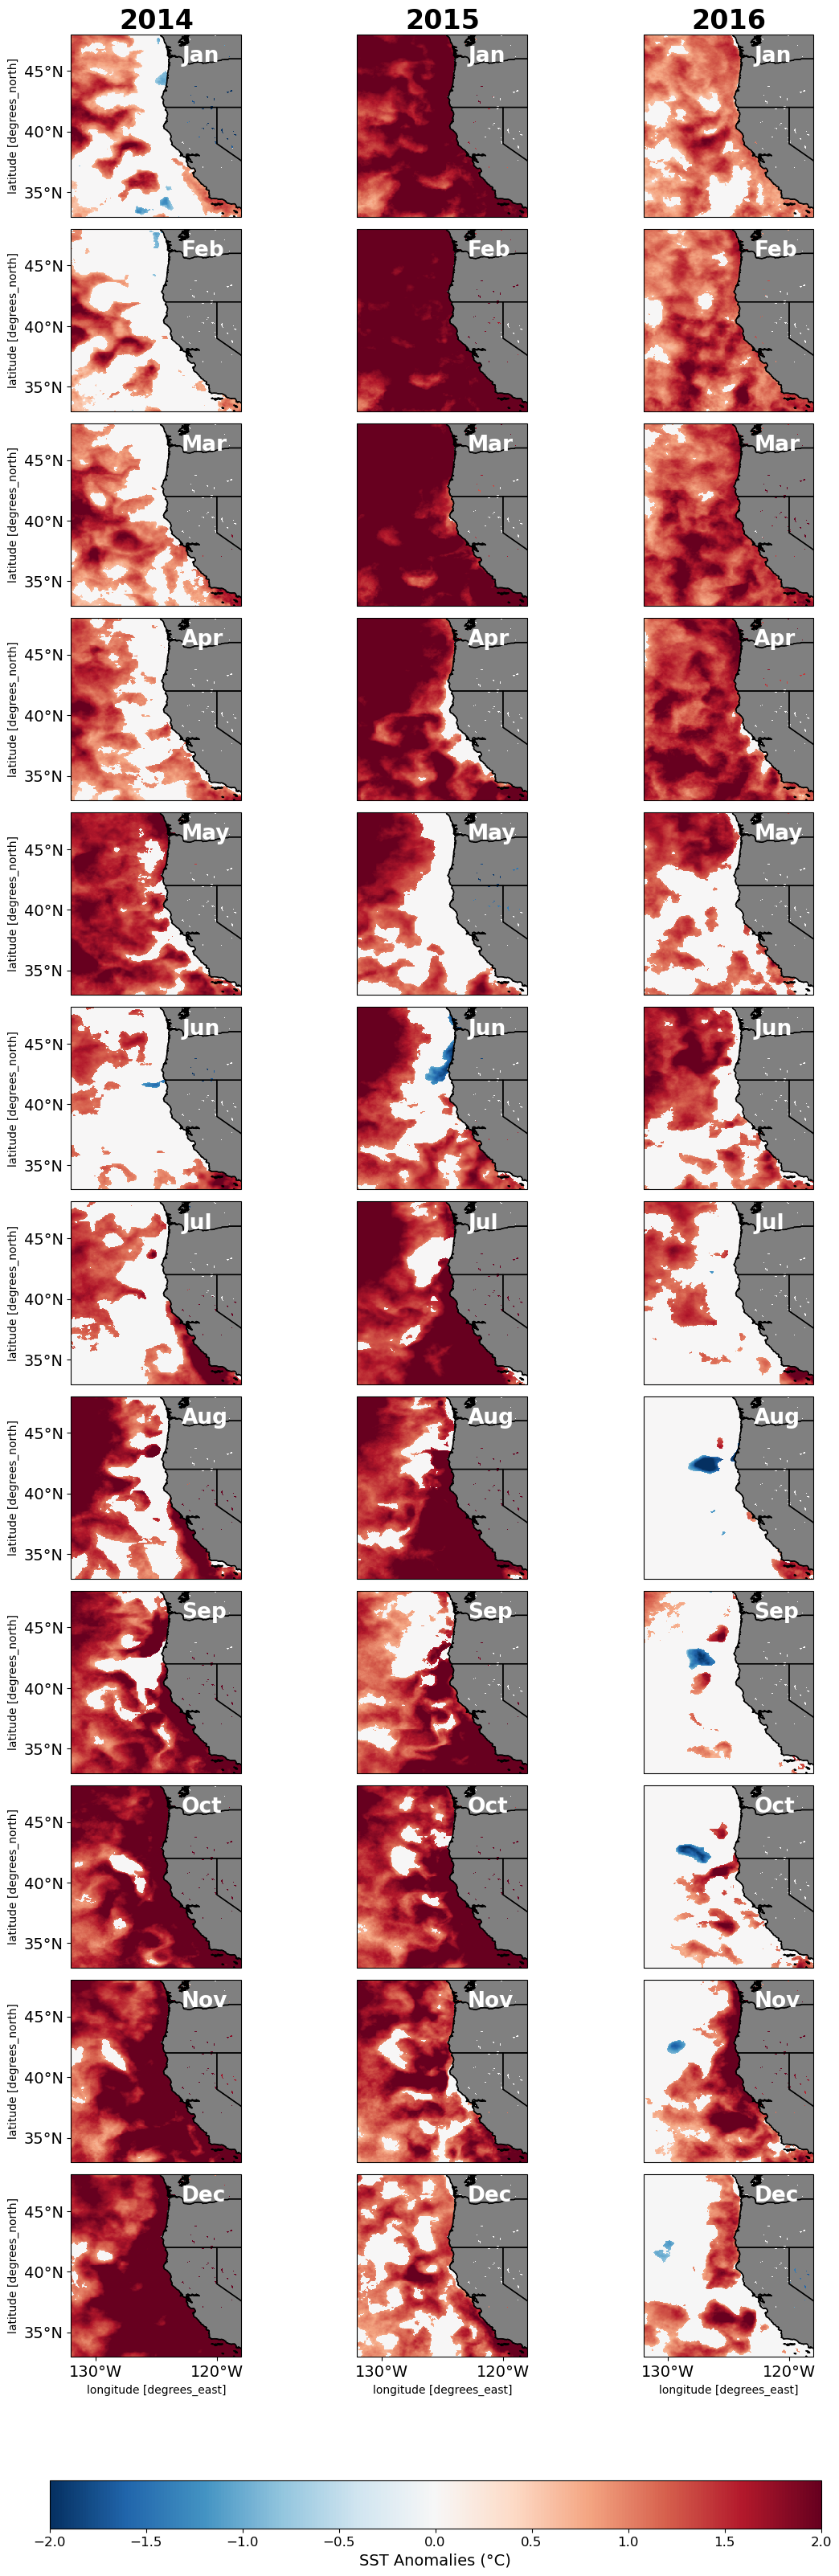

In [12]:

# create the plot with coastlines
fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(12, 30), subplot_kw={'projection': crs})

#For loops going through each month of each year of monthly_anomalies
for i, year in enumerate([2014, 2015, 2016]): 
    for j, month in enumerate(range(1,13)):    
        my_axes = axes[j,i]
        im = monthly_anomalies.sel(time = ((monthly_anomalies.time.dt.year == year) & (monthly_anomalies.time.dt.month==month))).analysed_sst.mean('time').plot.imshow(ax=my_axes, x="lon", y="lat",  robust=True, cmap = "RdBu_r",vmin= -2, vmax = 2, add_colorbar=False)
        my_axes.set_title("")
        my_axes.coastlines("10m", color="k")
        my_axes.add_feature(cfeature.LAND, color="grey")
        my_axes.add_feature(cfeature.STATES.with_scale("10m"))
        month_name = datetime.date(1900, month, 1).strftime('%b') #Placing the white month annotations
        my_axes.text(0.65, 0.85, month_name, transform=my_axes.transAxes, color='w', fontsize=19, fontweight='bold')
        if j == 11: #Placing the x-axis tick labels at the appropriate rows
            my_axes.set_xticks([-130, -120], crs=crs)
            my_axes.xaxis.set_major_formatter(LongitudeFormatter())
            my_axes.tick_params(axis='x', labelsize=14)
        if i == 0: #Placing the y-axis tick labels at the appropriate columns
            my_axes.set_yticks([35, 40, 45], crs=crs)
            my_axes.yaxis.set_major_formatter(LatitudeFormatter())
            my_axes.tick_params(axis='y', labelsize=14)
        if j == 11 and i == 2: # Add colorbar below the last row
            cax = fig.add_axes([0.1, -0.05, 0.8, 0.02]) # left, bottom, width, height
            cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
            cbar.set_label('SST Anomalies (°C)', fontsize=14)
            cbar.ax.tick_params(labelsize=12)

        if j == 0: #Placing the yearly titles
            my_axes.text(0.285, 1.03, year, transform=my_axes.transAxes, fontsize=24, fontweight='bold')

plt.savefig('outputs/q04.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

As seen in the figure, anomalies intensified during this time period between 2014-2016, almost exclusively being above the monthly mean for that area. The largest effects were between late 2014 and early 2015, with nearly entirely anomalies.